# Línea base por semanas

La idea del notebook es tener una primera línea base para las estaciones de SIMAJ, el código puede funcionar como base para replicarlo a las estaciones de Mi Macro

In [1]:
import os
import sys
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aqiGDL
%matplotlib inline

Colores y estilo de matplotlib a usar

In [3]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
colors = ['7A76C2', 'ff6e9c98', 'f62196', '18c0c4', 'f3907e', '66E9EC']

Carga de estaciones de monitoreo

In [36]:
gdf_est = aqiGDL.gdf_from_db('estaciones_gdl','Estaciones')
gdf_est = ox.project_gdf(gdf_est,to_crs='EPSG:32613')
gdf_est_simaj = aqiGDL.gdf_from_db('estaciones_simaj','estaciones_simaj')
gdf_est_simaj = ox.project_gdf(gdf_est_simaj,to_crs='EPSG:32613')
gdf_est_pip = aqiGDL.gdf_from_db('puntos_pip','Estaciones')
gdf_est_pip = ox.project_gdf(gdf_est_pip,to_crs='EPSG:32613')

Red base de Guadalajara

In [37]:
G = ox.graph_from_bbox(20.751857,20.523110,-103.201328,-103.468643)
edges = ox.graph_to_gdfs(G, nodes=False)
edges = ox.project_gdf(edges,to_crs=gdf_est_simaj.crs)

Carga de las mediciones usando un rango de fechas

In [4]:
est = 'ATM'
inicio = '2013/21/31'
fin = '2019/12/31'
query = f"SELECT * FROM data.simaj_data_day WHERE \"FECHA\" between \'{inicio}\' and \'{fin}\'"
df = aqiGDL.df_from_query(query)
df['FECHA'] = pd.to_datetime(df['FECHA']).dt.date
df.sort_values(by=['FECHA'], inplace=True)

In [3]:
df

FECHA PARAM EST_SIMAJ       CONC        LONG        LAT
36512  2014-01-01  PM10       LDO  62.104167 -103.263974  20.629295
36527  2014-01-01    CO       MIR   1.908875 -103.343333  20.614444
36528  2014-01-01    CO       PIN   1.799875 -103.326529  20.576824
36529  2014-01-01    CO       SFE   1.708292 -103.377179  20.529149
36530  2014-01-01   NO2       ATM   0.014292 -103.355435  20.719674
...           ...   ...       ...        ...         ...        ...
36470  2019-12-31    CO       AGU   0.909167 -103.416431  20.631268
36471  2019-12-31    CO       VAL   0.444222 -103.398551  20.680193
36472  2019-12-31    CO       ATM        NaN -103.355435  20.719674
36461  2019-12-31  PM10       VAL  19.961111 -103.398551  20.680193
36477  2019-12-31    CO       LDO   1.080167 -103.263974  20.629295

[109550 rows x 6 columns]

Crea dataframe para incluir promedios semanales

In [6]:
df_week = pd.DataFrame(columns=['S_ID','S_YEAR','PARAM','EST_SIMAJ','CONC','LONG','LAT'])
year = [2014,2015,2016,2017,2018,2019]

i=0

for y in year:
    
    for s in range(1,53):
        
        for p in df.PARAM.unique():
            
            for est in df.EST_SIMAJ.unique():
            
                df_week.loc[i]=['S'+str(s),'S'+str(s)+'-'+str(y), p,
                                est, np.nan, df.loc[df.EST_SIMAJ==est]['LONG'].iloc[0],
                                df.loc[df.EST_SIMAJ==est]['LAT'].iloc[0]]

                i+=1
                
df_week['PROM'] = np.nan
df_week['DESV_EST'] = np.nan


Calcula promedios por semana

In [7]:
interval = 7

for p in df.PARAM.unique():
        
    for est in df.EST_SIMAJ.unique():
                    
        df_analysis = df.loc[(df.PARAM==p)&(df.EST_SIMAJ==est)]

        divide = int(round((len(df_analysis)/7),0))

        s = 1

        for i in range(0, divide):

            mean_conc = df_analysis.iloc[i*interval:i*interval+interval]['CONC'].mean()

            std_conc = df_analysis.iloc[i*interval:i*interval+interval]['CONC'].std()

            day_year = i*interval+int((((i*interval+interval)-(i*interval))/2)-0.5)
            
            year_df = df_analysis['FECHA'].iloc[day_year].year
            
            df_week.loc[(df_week.S_ID=='S'+str(s)) & 
                      (df_week.S_YEAR=='S'+str(s)+'-'+str(year_df)) & 
                      (df_week.PARAM==p) &
                        (df_week.EST_SIMAJ==est),
                        'PROM'] = mean_conc

            df_week.loc[(df_week.S_ID=='S'+str(s)) & 
                      (df_week.S_YEAR=='S'+str(s)+'-'+str(year_df)) & 
                      (df_week.PARAM==p) &
                        (df_week.EST_SIMAJ==est),
                        'DESV_EST'] = std_conc

            s += 1

            if s > 52:

                s = 0
                

Filtra para un año en específico

In [8]:
df_week17 = df_week.iloc[2600:5200]
df_week17[(df_week17['PARAM']=='SO2')&(df_week17['EST_SIMAJ']=='AGU')]

S_ID    S_YEAR PARAM EST_SIMAJ  CONC        LONG        LAT      PROM  \
2639   S1   S1-2015   SO2       AGU   NaN -103.416431  20.631268  0.002163   
2689   S2   S2-2015   SO2       AGU   NaN -103.416431  20.631268  0.002222   
2739   S3   S3-2015   SO2       AGU   NaN -103.416431  20.631268  0.001592   
2789   S4   S4-2015   SO2       AGU   NaN -103.416431  20.631268  0.001519   
2839   S5   S5-2015   SO2       AGU   NaN -103.416431  20.631268  0.002141   
2889   S6   S6-2015   SO2       AGU   NaN -103.416431  20.631268  0.001621   
2939   S7   S7-2015   SO2       AGU   NaN -103.416431  20.631268  0.001183   
2989   S8   S8-2015   SO2       AGU   NaN -103.416431  20.631268  0.001372   
3039   S9   S9-2015   SO2       AGU   NaN -103.416431  20.631268  0.001912   
3089  S10  S10-2015   SO2       AGU   NaN -103.416431  20.631268  0.000527   
3139  S11  S11-2015   SO2       AGU   NaN -103.416431  20.631268  0.000000   
3189  S12  S12-2015   SO2       AGU   NaN -103.416431  20.631268  0.000000   
3239  S13  S13-2015   SO2       AGU   NaN -103.416431  20.631268  0.000517   
3289  S14  S14-2015   SO2       AGU   NaN -103.416431  20.631268  0.000673   
3339  S15  S15-2015   SO2       AGU   NaN -103.416431  20.631268  0.001151   
3389  S16  S16-2015   SO2       AGU   NaN -103.416431  20.631268  0.000893   
3439  S17  S17-2015   SO2       AGU   NaN -103.416431  20.631268  0.000746   
3489  S18  S18-2015   SO2       AGU   NaN -103.416431  20.631268  0.001475   
3539  S19  S19-2015   SO2       AGU   NaN -103.416431  20.631268  0.001009   
3589  S20  S20-2015   SO2       AGU   NaN -103.416431  20.631268  0.000707   
3639  S21  S21-2015   SO2       AGU   NaN -103.416431  20.631268  0.001460   
3689  S22  S22-2015   SO2       AGU   NaN -103.416431  20.631268  0.001221   
3739  S23  S23-2015   SO2       AGU   NaN -103.416431  20.631268  0.001031   
3789  S24  S24-2015   SO2       AGU   NaN -103.416431  20.631268  0.000966   
3839  S25  S25-2015   SO2       AGU   NaN -103.416431  20.631268  0.001343   
3889  S26  S26-2015   SO2       AGU   NaN -103.416431  20.631268  0.001165   
3939  S27  S27-2015   SO2       AGU   NaN -103.416431  20.631268  0.001468   
3989  S28  S28-2015   SO2       AGU   NaN -103.416431  20.631268  0.001385   
4039  S29  S29-2015   SO2       AGU   NaN -103.416431  20.631268  0.001241   
4089  S30  S30-2015   SO2       AGU   NaN -103.416431  20.631268  0.001079   
4139  S31  S31-2015   SO2       AGU   NaN -103.416431  20.631268  0.001080   
4189  S32  S32-2015   SO2       AGU   NaN -103.416431  20.631268  0.001220   
4239  S33  S33-2015   SO2       AGU   NaN -103.416431  20.631268  0.001381   
4289  S34  S34-2015   SO2       AGU   NaN -103.416431  20.631268  0.001711   
4339  S35  S35-2015   SO2       AGU   NaN -103.416431  20.631268  0.001468   
4389  S36  S36-2015   SO2       AGU   NaN -103.416431  20.631268  0.000894   
4439  S37  S37-2015   SO2       AGU   NaN -103.416431  20.631268  0.001365   
4489  S38  S38-2015   SO2       AGU   NaN -103.416431  20.631268  0.001750   
4539  S39  S39-2015   SO2       AGU   NaN -103.416431  20.631268  0.001995   
4589  S40  S40-2015   SO2       AGU   NaN -103.416431  20.631268  0.001691   
4639  S41  S41-2015   SO2       AGU   NaN -103.416431  20.631268  0.002480   
4689  S42  S42-2015   SO2       AGU   NaN -103.416431  20.631268  0.001970   
4739  S43  S43-2015   SO2       AGU   NaN -103.416431  20.631268  0.001922   
4789  S44  S44-2015   SO2       AGU   NaN -103.416431  20.631268  0.001956   
4839  S45  S45-2015   SO2       AGU   NaN -103.416431  20.631268  0.002128   
4889  S46  S46-2015   SO2       AGU   NaN -103.416431  20.631268  0.002283   
4939  S47  S47-2015   SO2       AGU   NaN -103.416431  20.631268  0.002309   
4989  S48  S48-2015   SO2       AGU   NaN -103.416431  20.631268  0.002397   
5039  S49  S49-2015   SO2       AGU   NaN -103.416431  20.631268  0.002365   
5089  S50  S50-2015   SO2       AGU   NaN -103.416431  20.631268  0.002478   
5139  S51  S51-2015   SO2  

## Plot 📈

In [117]:
errors = []
for est in df_week17.EST_SIMAJ.unique().tolist():
    try:
        fig, axes = plt.subplots(2,3,figsize=(16,9), sharex=True)
        for param, ax, color in zip(df_week17.PARAM.unique().tolist(), axes.flatten()[1:], colors):
            df_temp = df_week17[(df_week17['EST_SIMAJ']==est) & (df_week17['PARAM']==param)]
            ax.plot(df_temp['S_YEAR'], df_temp['PROM'], label=param, color='#'+color)
            ax.set_title(param,fontsize=15)
            if param == 'SO2' or param == 'PM10':
                ax.set_xticklabels([])
            else:
                ax.tick_params(labelrotation=45)
        
        a00 = axes[0,0]
        shax = a00.get_shared_x_axes()
        shax.remove(a00)
        edges.plot(ax=axes[0][0], color='#e8e9eb',linewidth=0.1, zorder=-1)
        edges[(edges['highway']=='primary') | (edges['highway']=='secondary')].plot(ax=axes[0][0], color='#e8e9eb',linewidth=0.5, zorder=0)
        gdf_est_simaj.plot(ax=axes[0][0], color='k', alpha=0.85, zorder=1)
        gdf_est_simaj[gdf_est_simaj['codigo']==est].plot(ax=axes[0][0], color='#ba0d38', alpha=0.85, zorder=2, markersize=90)
        axes[0][0].axis('off')
        estacion = gdf_est_simaj[gdf_est_simaj['codigo']==est]['nombre'].values[0]
        fecha_1 = df['FECHA'].min().strftime('%Y-%m-%d') 
        fecha_2 = df['FECHA'].max().strftime('%Y-%m-%d') 
        fig.suptitle(f'{estacion}\n{fecha_1} -- {fecha_2}', fontsize=20)
        plt.savefig(f'../output/figures/estsimaj/{est}_{fecha_1}.png',dpi=300)
        plt.close()
    except Exception as e:
        errors.append(est)
        pass

In [121]:
errors

[]

In [7]:
errors = []
for est in df_week17.EST_SIMAJ.unique().tolist():
    try:
        fig, axes = plt.subplots(2,3,figsize=(16,9), sharex=True)
        for param, ax, color in zip(df_week17.PARAM.unique().tolist(), axes.flatten()[1:], colors):
            df_temp = df_week17[(df_week17['EST_SIMAJ']==est) & (df_week17['PARAM']==param)]
            ax.plot(df_temp['S_YEAR'], df_temp['PROM'], label=param, color='#'+color)

            #rellena el espacio entre desviaciones estandar
            ax.fill_between(range(len(df_temp)), 
                                   df_temp['DESV_EST']*-1+df_temp['PROM'], 
                                    df_temp['DESV_EST']*1+df_temp['PROM'], 
                                   facecolor='#9ddc9b', 
                                   alpha=0.25)
            
            ax.set_title(param,fontsize=15)
            '''if param == 'SO2' or param == 'PM10':
                ax.set_xticklabels([])
            else:
                ax.tick_params(labelrotation=45)'''
            
            ax.tick_params(
                            axis='x',          # changes apply to the x-axis
                            which='both',      # both major and minor ticks are affected
                            bottom=False,      # ticks along the bottom edge are off
                            top=False,         # ticks along the top edge are off
                            labelbottom=False) # labels along the bottom edge are off
                
        
        a00 = axes[0,0]
        shax = a00.get_shared_x_axes()
        shax.remove(a00)
        edges.plot(ax=axes[0][0], color='#e8e9eb',linewidth=0.1, zorder=-1)
        edges[(edges['highway']=='primary') | (edges['highway']=='secondary')].plot(ax=axes[0][0], color='#e8e9eb',linewidth=0.5, zorder=0)
        gdf_est_pip.plot(ax=axes[0][0], color='k', alpha=0.85, zorder=1)
        gdf_est_pip[gdf_est_pip['Nombre']==est].plot(ax=axes[0][0], color='#ba0d38', alpha=0.85, zorder=2, markersize=90)
        axes[0][0].axis('off')
        estacion = gdf_est_pip[gdf_est_pip['Nombre']==est]['Nombre'].values[0]
        #fecha_1 = df['FECHA'].min().strftime('%Y-%m-%d') 
        fecha_1 = '2014-01-01'
        #fecha_2 = df['FECHA'].max().strftime('%Y-%m-%d')
        fecha_2 = '2019-12-31'
        fig.suptitle(f'{estacion}\n{fecha_1} -- {fecha_2}', fontsize=20)
        #plt.savefig(f'../output/figures/estsimaj/{est}_{fecha_1}.png',dpi=300)
        #plt.close()
    except Exception as e:
        errors.append(est)
        pass

NameError: name 'df_week17' is not defined

In [32]:
df_week = aqiGDL.df_from_db('pip_data_week','data')
df_week.head(1)

CONC        LONG        LAT PARAM                       EST_PIP S_ID  \
0  36.774319 -103.391246  20.722076  PM10  Mercado Municipal de Zapopan   S1   

    S_YEAR       STD  
0  S1-2014  9.006851

In [33]:
df_week.CONC.min()

0.0002540841215097598

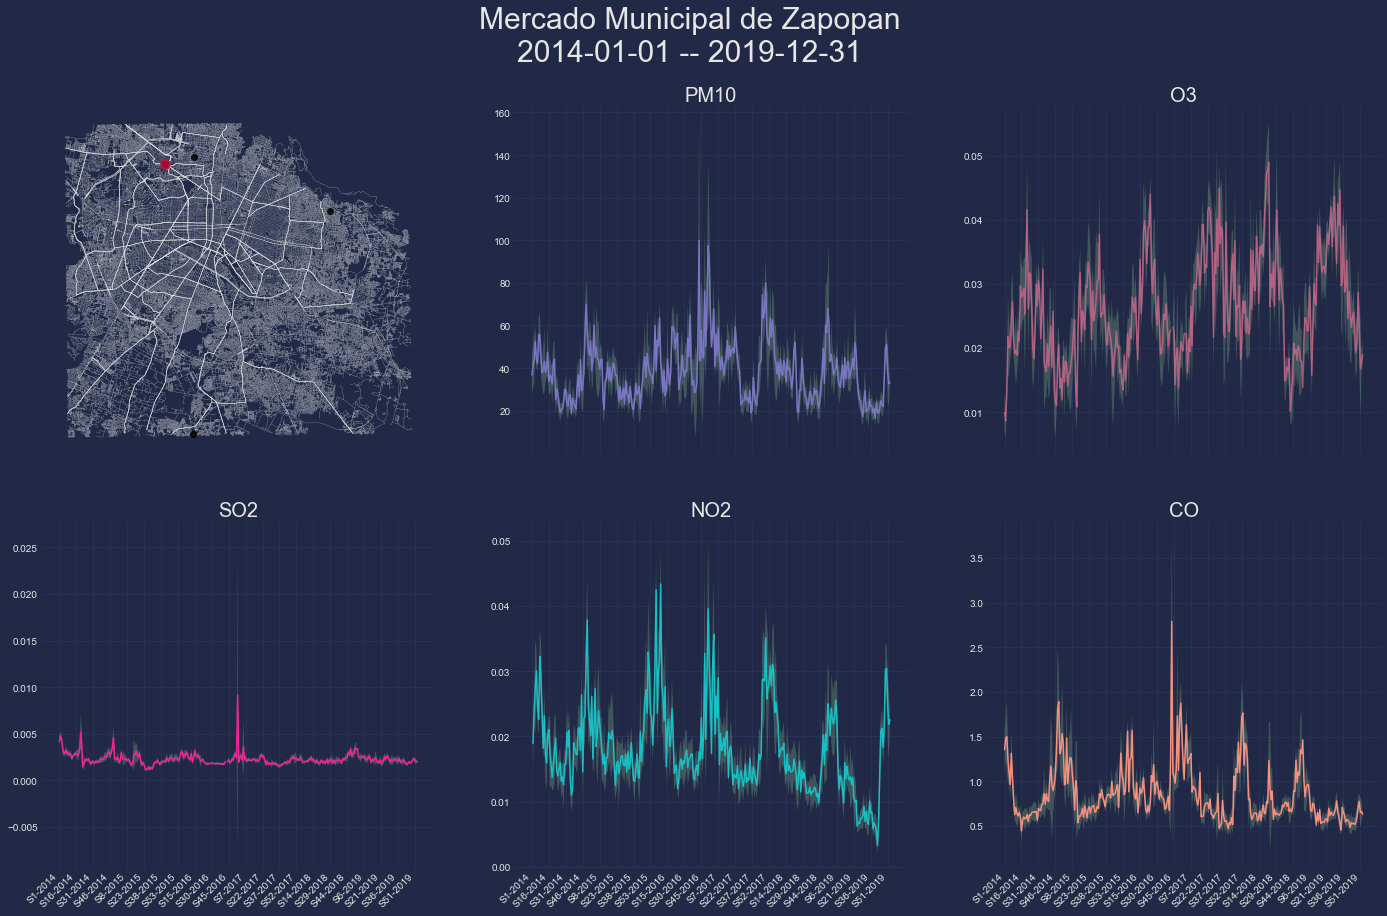

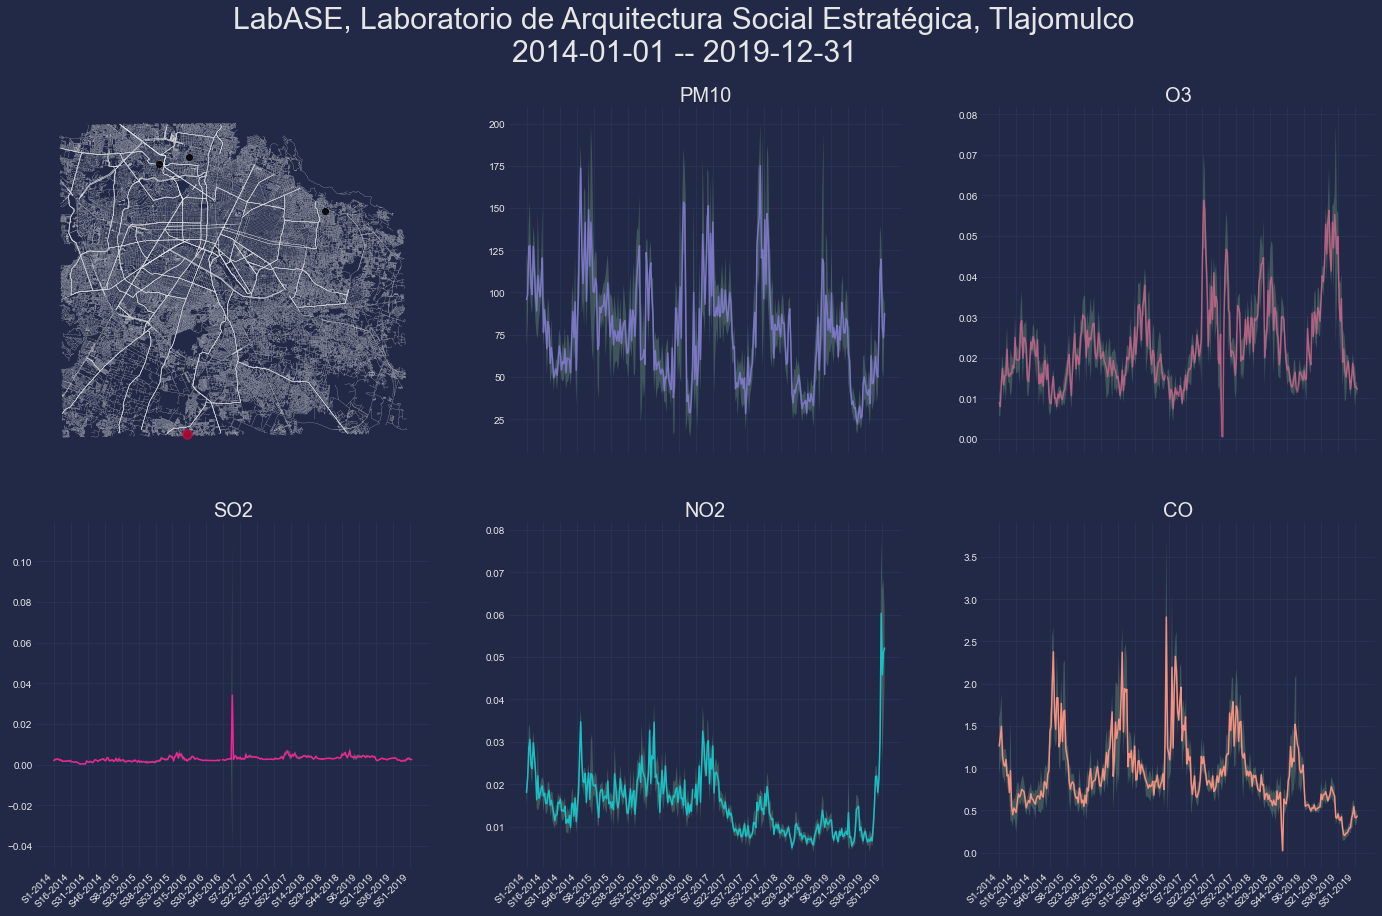

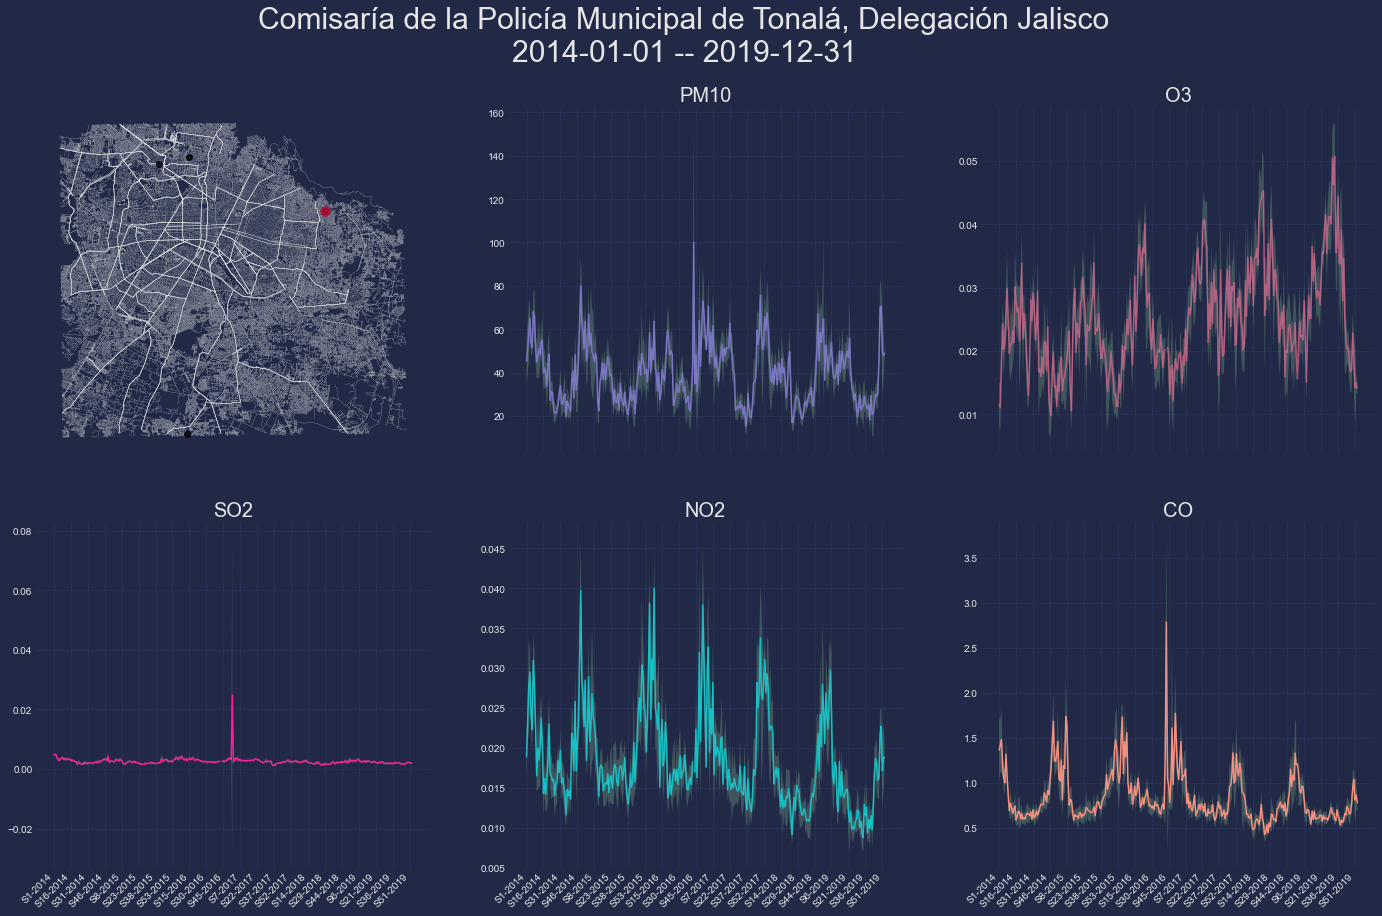

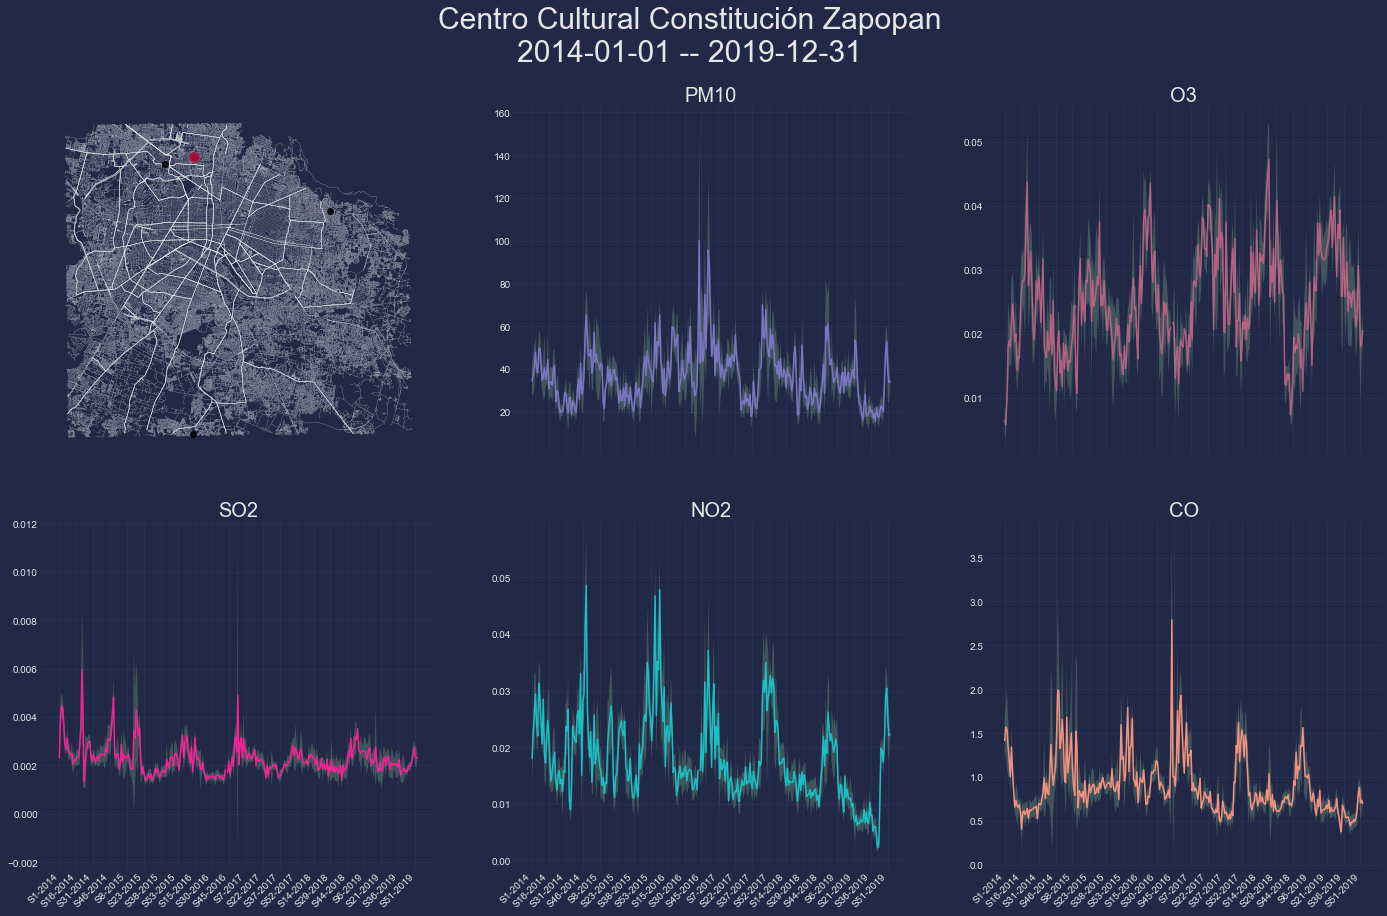

In [39]:
errors = []
for est in df_week.EST_PIP.unique().tolist():
    try:
        fig, axes = plt.subplots(2,3,figsize=(24,14), sharex=True)
        for param, ax, color in zip(df_week.PARAM.unique().tolist(), axes.flatten()[1:], colors):
            df_temp = df_week[(df_week['EST_PIP']==est) & (df_week['PARAM']==param)]
            ax.plot(df_temp['S_YEAR'], df_temp['CONC'], label=param, color='#'+color)

            #rellena el espacio entre desviaciones estandar
            ax.fill_between(range(len(df_temp)), 
                                   df_temp['STD']*-1+df_temp['CONC'], 
                                    df_temp['STD']*1+df_temp['CONC'], 
                                   facecolor='#9ddc9b', 
                                   alpha=0.25)
            
            ax.set_title(param,fontsize=20)
            ax.tick_params(axis='x',labelrotation=45)
           
        
        x_ticks = np.arange(0, len(df_temp['S_YEAR']),15)
        for i in range(0,3):
            plt.sca(axes[1, i])
            plt.xticks(x_ticks, horizontalalignment="right");
    
        a00 = axes[0,0]
        shax = a00.get_shared_x_axes()
        shax.remove(a00)
        edges.plot(ax=axes[0][0], color='#e8e9eb',linewidth=0.1, zorder=-1)
        edges[(edges['highway']=='primary') | (edges['highway']=='secondary')].plot(ax=axes[0][0], color='#e8e9eb',linewidth=0.5, zorder=0)
        gdf_est_pip.plot(ax=axes[0][0], color='k', alpha=0.85, zorder=1)
        gdf_est_pip[gdf_est_pip['Nombre']==est].plot(ax=axes[0][0], color='#ba0d38', alpha=0.85, zorder=2, markersize=90)
        axes[0][0].axis('off')
        estacion = gdf_est_pip[gdf_est_pip['Nombre']==est]['Nombre'].values[0]
        fecha_1 = '2014-01-01'
        fecha_2 = '2019-12-31'
        fig.suptitle(f'{estacion}\n{fecha_1} -- {fecha_2}', fontsize=30)
        
        plt.savefig(f'../output/figures/estpip/{est}_{fecha_1}_{fecha_2}.png',dpi=300)
        #plt.close()
    except Exception as e:
        errors.append(est)
        pass